In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

import random
from collections import defaultdict

%matplotlib inline

In [2]:
DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness"

In [3]:
YEAR = 2019
raw_tournament_df = pd.read_csv(f"{DATA_DIR}/output/teams.csv")
tournament_df = raw_tournament_df[raw_tournament_df["Season"] == YEAR]
tournament_df

,Season,TeamID,TeamName,Seed,SeedInt,OwnScore_Zscore,OppScore_Zscore,Offense,Dominance,SOS,Competition,Wins
0,2019,1101,Abilene Chr,Y15,15,-0.021108,-0.375821,-2.004979,-0.677338,-1.942276,-0.894141,0.0
42,2019,1113,Arizona St,X11a,11,0.540309,-0.020030,3.597716,2.568070,1.451221,0.934887,0.0
54,2019,1120,Auburn,Y05,5,0.668713,-0.330004,0.850966,3.250229,1.964265,1.364965,4.0
65,2019,1124,Baylor,X09,9,0.171236,-0.367754,-0.346217,1.919532,1.525257,1.131600,1.0
73,2019,1125,Belmont,W11a,11,1.075292,-0.026807,0.901575,3.871800,-0.347517,-0.150465,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2019,1439,Virginia Tech,W04,4,0.306598,-0.752115,-3.730767,3.649246,1.604288,1.110126,2.0
1055,2019,1449,Washington,Y09,9,-0.083146,-0.713522,-1.629446,1.834973,1.394724,0.859612,1.0
1107,2019,1458,Wisconsin,Z05,5,-0.115887,-0.929001,-4.360194,3.614546,2.304010,1.560116,0.0
1112,2019,1459,Wofford,Y07,7,0.598993,-0.527340,-2.922797,2.342440,-0.091967,0.097317,1.0


In [4]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
# Get slots, and order with play ins first
slots_df = pd.read_csv(f"{DATA_DIR}/MNCAATourneySlots.csv")
slots_df = slots_df[slots_df["Season"] == YEAR]
slots_df = pd.concat([
    slots_df[~slots_df["Slot"].str.startswith("R")],
    slots_df[slots_df["Slot"].str.startswith("R")]
])
slots_df

,Season,Slot,StrongSeed,WeakSeed
2247,2019,W11,W11a,W11b
2248,2019,W16,W16a,W16b
2249,2019,X11,X11a,X11b
2250,2019,X16,X16a,X16b
2184,2019,R1W1,W01,W16
...,...,...,...,...
2242,2019,R4Y1,R3Y1,R3Y2
2243,2019,R4Z1,R3Z1,R3Z2
2244,2019,R5WX,R4W1,R4X1
2245,2019,R5YZ,R4Y1,R4Z1


In [5]:
games_df = pd.read_csv(f"{DATA_DIR}/output/games_training.csv")
games_df

,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OwnScore_Zscore_B,OppScore_Zscore_A,OppScore_Zscore_B,Offense_A,Offense_B,Dominance_A,Dominance_B,SOS_A,SOS_B,Competition_A,Competition_B,Win_A
0,2003,1104,1328,0.144799,0.207507,-0.335313,-0.863963,-0.755118,-3.573729,3.420866,3.564440,1.808134,2.096693,1.378512,1.181115,True
1,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.573729,2.197156,3.564440,4.765952,2.096693,2.262017,1.181115,1.321327,False
2,2003,1328,1400,0.207507,0.935597,-0.863963,-0.181307,-3.573729,2.197156,3.564440,4.765952,2.096693,2.262017,1.181115,1.321327,False
3,2003,1281,1328,0.297116,0.207507,-0.342031,-0.863963,-0.563626,-3.573729,3.422770,3.564440,2.253370,2.096693,1.340966,1.181115,True
4,2003,1328,1329,0.207507,-0.064060,-0.863963,-0.740947,-3.573729,-1.235750,3.564440,2.115384,2.096693,1.873837,1.181115,1.223438,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4952,2019,1209,1243,0.283263,-0.404416,0.032907,-1.112603,1.561782,-5.395697,1.030750,2.069184,0.129268,1.852485,0.113073,1.377838,False
4953,2019,1209,1285,0.283263,0.099479,0.032907,-0.340951,1.561782,-2.116064,1.030750,-0.055944,0.129268,-0.800677,0.113073,-0.561377,False
4954,2019,1209,1251,0.283263,-0.223065,0.032907,-0.890404,1.561782,-6.511350,1.030750,0.485783,0.129268,-0.427815,0.113073,-0.157060,False
4955,2019,1124,1341,0.171236,0.336226,-0.367754,0.325131,-0.346217,2.933735,1.919532,-1.405578,1.525257,-1.674359,1.131600,-0.969110,True


In [6]:
# Train predictor based on derived offense and quality metrics
predict_df = games_df[[
    "OwnScore_Zscore_A", "OwnScore_Zscore_B",
    "OppScore_Zscore_A", "OppScore_Zscore_B",
    "Offense_A", "Offense_B",
    "Dominance_A", "Dominance_B",
    "SOS_A", "SOS_B",
    "Competition_A", "Competition_B"
]]

scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(predict_df),
    columns=predict_df.columns
) 

reg = LogisticRegression().fit(
    data_scaled,
    games_df[["Win_A"]]
)
reg.score(
    data_scaled,
    games_df[["Win_A"]]
), reg.coef_

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.6572523703853137,
 array([[ 0.33550314, -0.38278248, -0.40732481,  0.33624574, -0.00098818,
          0.10131534,  0.17153786, -0.15993257,  0.05296984, -0.00327395,
          0.52275842, -0.52320102]]))

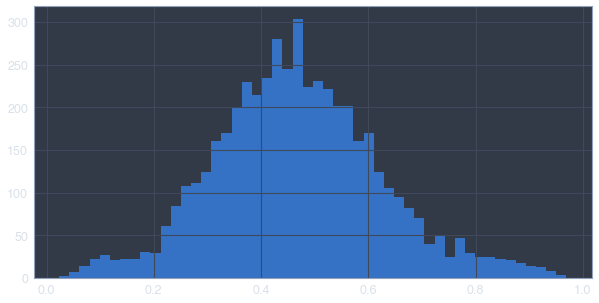

In [7]:
# Sanity check probability distribution
plt.figure(figsize=(10,5));
probs = [
    a for a, b in reg.predict_proba(predict_df)
]
plt.hist(probs, bins=50);

In [8]:
average_team = raw_tournament_df.mean().to_dict()
average_team

{'Season': 2011.095406360424,
 'TeamID': 1294.6272084805653,
 'SeedInt': 8.719081272084805,
 'OwnScore_Zscore': 0.3944827165002876,
 'OppScore_Zscore': -0.32319314544724476,
 'Offense': -0.256252553930219,
 'Dominance': 2.844700013740906,
 'SOS': 0.8632405322010391,
 'Competition': 0.5983000533920345,
 'Wins': 0.946113074204947}

In [9]:
from functools import lru_cache

@lru_cache(maxsize=4096)
def calc_prob(predict_data):
    return reg.predict_proba(scaler.transform([predict_data]))[0][1]

def get_power_rating(team):
    return calc_prob((
            team["OwnScore_Zscore"], average_team["OwnScore_Zscore"],
            team["OppScore_Zscore"], average_team["OppScore_Zscore"],
            team["Offense"], average_team["Offense"],
            team["Dominance"], average_team["Dominance"],
            team["SOS"], average_team["SOS"],
            team["Competition"], average_team["Competition"],
        ))

In [10]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    for line in range(len(x)):
         p1.text(
             x.iloc[line]+0.02, y.iloc[line], 
             labelseries.iloc[line], size=labelsize, color=labelcolor
         )
    return p1

In [11]:
# Best teams of all time
raw_tournament_df["PowerRating"] = raw_tournament_df.apply(get_power_rating, axis=1)
raw_tournament_df["PowerOdds"] = raw_tournament_df["PowerRating"] / (1-raw_tournament_df["PowerRating"])
raw_tournament_df["PowerLogOdds"] = np.log(raw_tournament_df["PowerOdds"])

raw_tournament_df.sort_values(by="PowerRating", ascending=False)[[
    "Season", "TeamName", "Seed", "PowerRating"
]][:25]

,Season,TeamName,Seed,PowerRating
403,2015,Kentucky,Y01,0.935074
514,2019,Michigan St,W02,0.910091
208,2004,Duke,W01,0.903923
223,2019,Duke,W01,0.902661
1030,2019,Virginia,Z01,0.893859
612,2005,North Carolina,Z01,0.891379
33,2014,Arizona,Z01,0.891346
1104,2015,Wisconsin,Z01,0.890516
371,2010,Kansas,Y01,0.886428
209,2005,Duke,Y01,0.885292


In [12]:
raw_tournament_df.groupby("Season").mean()[[
    "Dominance", "Competition", "PowerRating"
]]

,Dominance,Competition,PowerRating
Season,,,
2003,2.727162,0.566451,0.499773
2004,2.726832,0.584435,0.510007
2005,2.969583,0.559450,0.505353
2006,2.771641,0.539683,0.493455
2007,2.709088,0.555194,0.500154
2008,2.849585,0.556947,0.505845
2009,2.951572,0.619772,0.514351
2010,2.991176,0.595632,0.531699
2011,2.864481,0.629250,0.527038


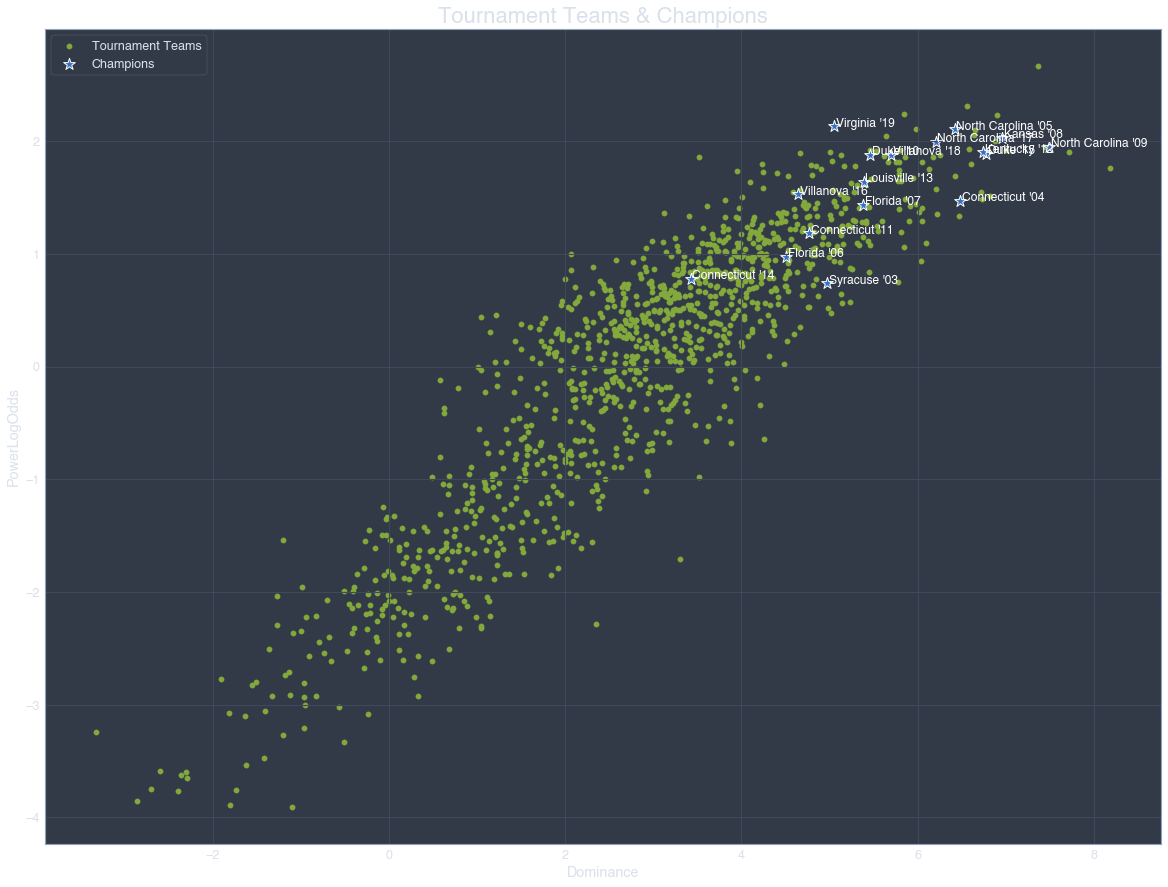

In [13]:
is_champion = raw_tournament_df["Wins"] >= 6
label_series = (
    raw_tournament_df[is_champion]["TeamName"] + " '" +
    raw_tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("Tournament Teams & Champions", fontsize=22)
plt.scatter(raw_tournament_df["Dominance"], raw_tournament_df["PowerLogOdds"], color='g', label='Tournament Teams');
scatter_text(
    raw_tournament_df[is_champion]["Dominance"], raw_tournament_df[is_champion]["PowerLogOdds"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

In [14]:
power_ratings = {}
slots_wins = defaultdict(lambda: defaultdict(int))
total_stats = defaultdict(lambda: defaultdict(int))
simulation_progression = []

SIMULATION_ROUNDS = 5000
SIM_MOD = SIMULATION_ROUNDS / 10
TOP_N = 5
for i in tqdm(range(SIMULATION_ROUNDS)):
    # INITIALIZE BRACKET (will be updated durign simulation)
    slots_dict = {
        row["Seed"]: row
        for _, row in tournament_df.iterrows()
    }
    
    for _, r in slots_df.iterrows():
        team_a = slots_dict[r["StrongSeed"]]
        team_b = slots_dict[r["WeakSeed"]]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["Offense"], team_b["Offense"],
            team_a["Dominance"], team_b["Dominance"],
            team_a["SOS"], team_b["SOS"],
            team_a["Competition"], team_b["Competition"],
        )
        prob = calc_prob(predict_data)
        winning_team = team_a if random.random() < prob else team_b
        slots_dict[r["Slot"]] = winning_team
        slots_wins[r["Slot"]][winning_team["TeamID"]] += 1
        total_stats[winning_team["TeamID"]]["wins"] += 1
        if r["Slot"][1] == "3":
            total_stats[winning_team["TeamID"]]["elite8"] += 1
        if r["Slot"][1] == "4":
            total_stats[winning_team["TeamID"]]["final4"] += 1
        
        # Get "difficulty" by looking at opposing power ratings
        power_a = get_power_rating(team_a)
        power_ratings[team_a["TeamID"]] = power_a
        total_stats[team_b["TeamID"]]["opp_power"] += power_a
        total_stats[team_b["TeamID"]]["opp_power_count"] += 1
        
        power_b = get_power_rating(team_b)
        power_ratings[team_b["TeamID"]] = power_b
        total_stats[team_a["TeamID"]]["opp_power"] += power_b
        total_stats[team_a["TeamID"]]["opp_power_count"] += 1
    
    # last winning team is champion
    total_stats[winning_team["TeamID"]]["championships"] +=1
    
    # Track top teams
    if (len(total_stats) > TOP_N) and ((i + 1) % SIM_MOD == 0):
        teams_by_championships = sorted(
            total_stats.items(), key=lambda x: x[1]["championships"], reverse=True
        )
        for team_id, stats in teams_by_championships[:TOP_N]:
            simulation_progression.append({
                "TeamID": team_id,
                "PercentChampion": stats["championships"] / (i + 1),
                "Rounds": i + 1
            })

100%|██████████| 5000/5000 [00:51<00:00, 97.95it/s] 


In [15]:
power_df = pd.DataFrame([{"TeamID": k, "PowerRating": v} for k, v in power_ratings.items()])
tournament_df = tournament_df.merge(power_df, on="TeamID")

In [16]:
simulation_df = pd.DataFrame([
    {
        "TeamID": team_id,
        "AvgOppPower": results_dict["opp_power"] / results_dict["opp_power_count"],
        "MeanWins": results_dict["wins"] / SIMULATION_ROUNDS,
        "PercentElite8": results_dict["elite8"] / SIMULATION_ROUNDS,
        "PercentFinal4": results_dict["final4"] / SIMULATION_ROUNDS,
        "PercentChampion": results_dict["championships"] / SIMULATION_ROUNDS
    }
    for team_id, results_dict in total_stats.items()
])
simulation_df = simulation_df.merge(tournament_df, on="TeamID")[[
    "TeamID", "TeamName", "Seed",
    "Offense",
    "Dominance",
    "Competition",
    "AvgOppPower",
    "PowerRating",
    "MeanWins",
    "PercentElite8",
    "PercentFinal4",
    "PercentChampion",
    "Wins"
]]

In [17]:
simulation_df["LogOdds"] = np.log(
    simulation_df["PercentChampion"] / (1-simulation_df["PercentChampion"])
).replace([np.inf, -np.inf], np.nan)
simulation_df["LogOdds"] = simulation_df["LogOdds"].fillna(simulation_df["LogOdds"].min())

/Users/jameswhedbee/miniforge3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


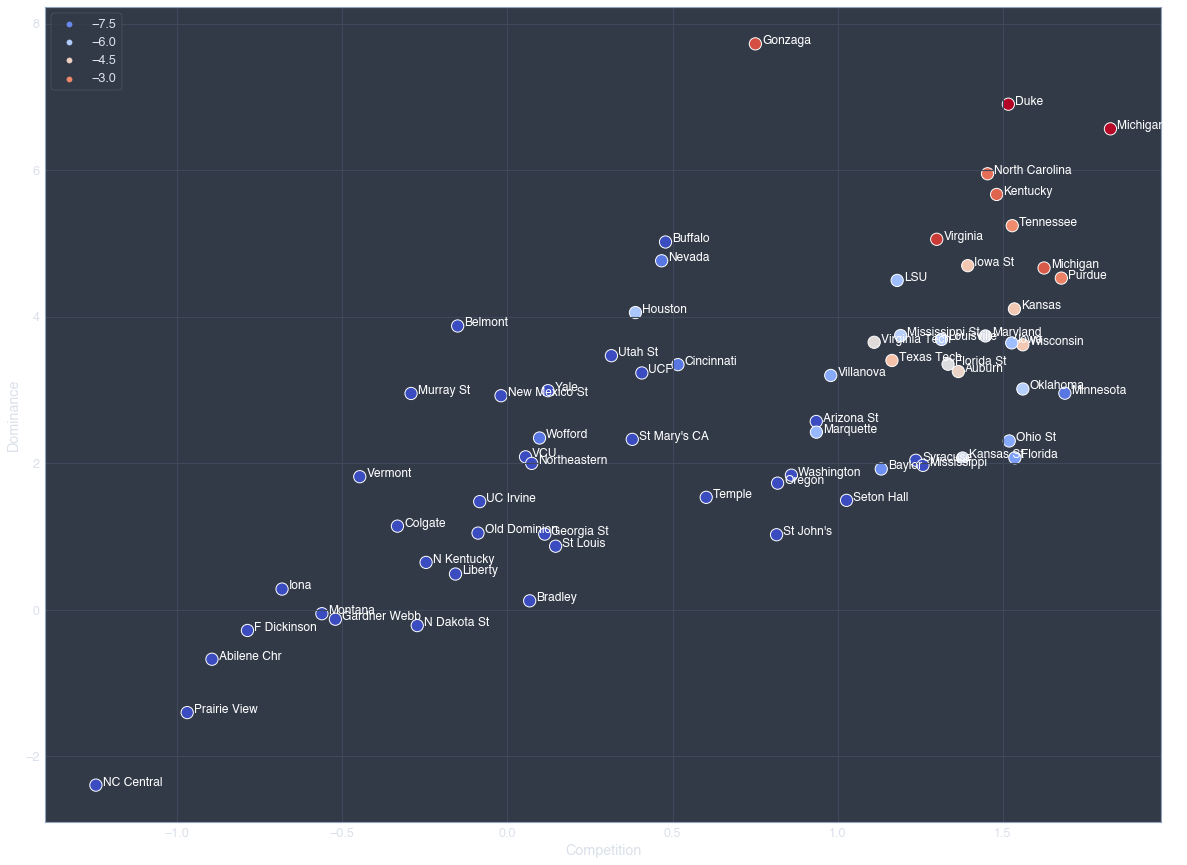

In [18]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["Competition"], y=simulation_df["Dominance"], s=150,
    hue=simulation_df["LogOdds"],
    palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white",
);
plt.legend(loc='upper left');

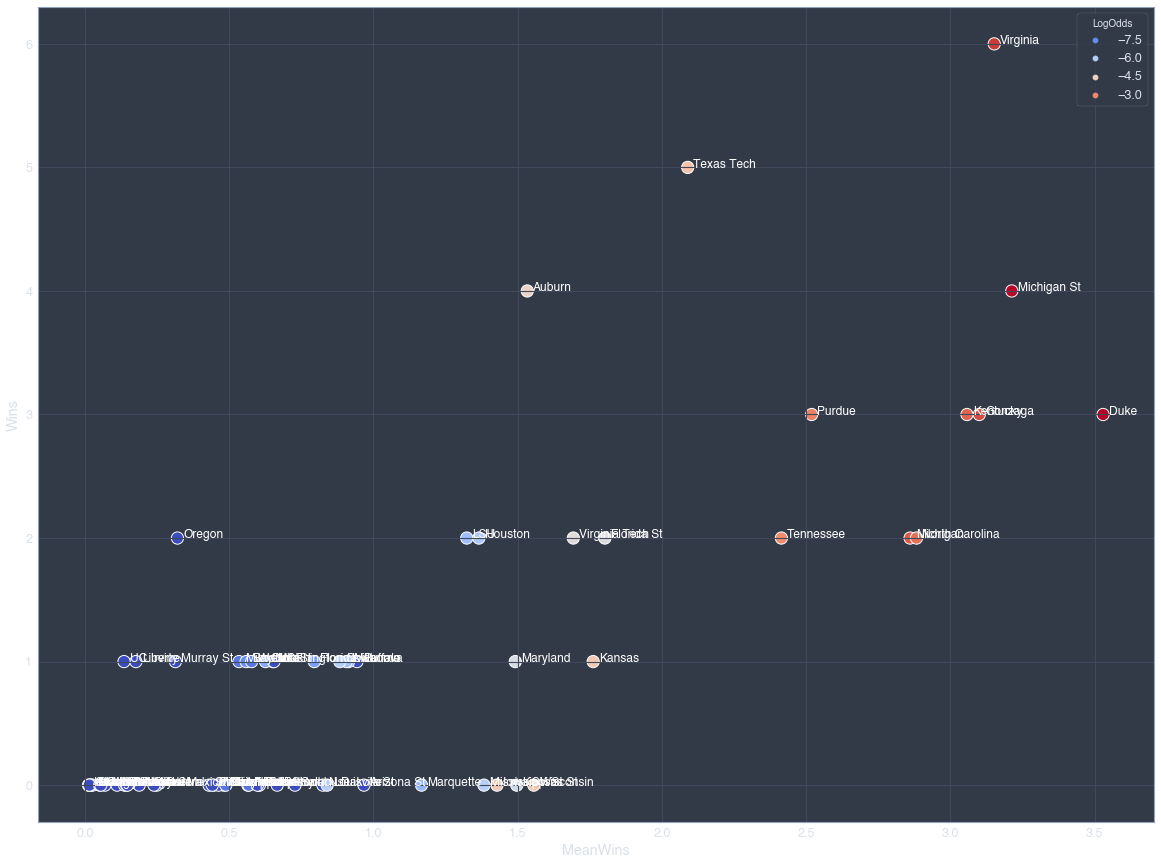

In [19]:
plt.figure(figsize=(20,15));
scatter_text(
    x=simulation_df["MeanWins"], y=simulation_df["Wins"], s=150,
    hue=simulation_df["LogOdds"], palette=sns.color_palette("coolwarm", as_cmap=True),
    labelseries=simulation_df["TeamName"], labelcolor="white"
);

In [20]:
BASIC_COLUMNS = ["TeamName", "Seed", "MeanWins", "PercentElite8", "PercentFinal4", "PercentChampion"]

In [21]:
# Who is the best team?
simulation_df.sort_values("PowerRating", ascending=False)[["PowerRating"] + BASIC_COLUMNS][:30]

,PowerRating,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
9,0.910091,Michigan St,W02,3.2126,0.6480,0.3726,0.1674
8,0.902661,Duke,W01,3.5290,0.7268,0.4442,0.1738
52,0.893859,Virginia,Z01,3.1518,0.6060,0.3934,0.1218
22,0.870400,Gonzaga,X01,3.1000,0.6334,0.3784,0.0996
23,0.869599,Michigan,X02,2.8600,0.5526,0.3200,0.0870
38,0.860263,Kentucky,Y02,3.0572,0.6090,0.3438,0.0760
56,0.844230,Purdue,Z03,2.5188,0.4370,0.2176,0.0518
36,0.841764,North Carolina,Y01,2.8822,0.5390,0.3116,0.0666
54,0.836236,Tennessee,Z02,2.4140,0.4034,0.1924,0.0444
60,0.805844,Wisconsin,Z05,1.5556,0.1726,0.0816,0.0142


In [22]:
# Who has the easiest schedule on average (excluding play ins)
is_not_play_in =  ~simulation_df["Seed"].str[-1].apply(str.isalpha)
simulation_df[is_not_play_in].sort_values(
    "AvgOppPower", ascending=True)[["AvgOppPower"] + BASIC_COLUMNS][:16]

,AvgOppPower,TeamName,Seed,MeanWins,PercentElite8,PercentFinal4,PercentChampion
38,0.520291,Kentucky,Y02,3.0572,0.6090,0.3438,0.0760
27,0.522129,Florida St,X04,1.8022,0.2066,0.0786,0.0062
40,0.530005,Houston,Y03,1.3654,0.1034,0.0292,0.0020
36,0.530118,North Carolina,Y01,2.8822,0.5390,0.3116,0.0666
25,0.539219,Texas Tech,X03,2.0892,0.2770,0.1242,0.0162
29,0.545547,Marquette,X05,1.1666,0.0718,0.0242,0.0014
22,0.546385,Gonzaga,X01,3.1000,0.6334,0.3784,0.0996
15,0.556175,Mississippi St,W05,1.3830,0.0946,0.0278,0.0026
8,0.557630,Duke,W01,3.5290,0.7268,0.4442,0.1738
13,0.559930,Virginia Tech,W04,1.6928,0.1520,0.0512,0.0070


In [23]:
# Who has the best chance to win
pie_df = simulation_df.sort_values("PercentChampion", ascending=False)
pie_df[[
    "TeamName", "Seed", "PowerRating", "AvgOppPower", "PercentElite8", "PercentFinal4", "PercentChampion"
]][:10]

,TeamName,Seed,PowerRating,AvgOppPower,PercentElite8,PercentFinal4,PercentChampion
8,Duke,W01,0.902661,0.557630,0.7268,0.4442,0.1738
9,Michigan St,W02,0.910091,0.611757,0.6480,0.3726,0.1674
52,Virginia,Z01,0.893859,0.584336,0.6060,0.3934,0.1218
22,Gonzaga,X01,0.870400,0.546385,0.6334,0.3784,0.0996
23,Michigan,X02,0.869599,0.581355,0.5526,0.3200,0.0870
38,Kentucky,Y02,0.860263,0.520291,0.6090,0.3438,0.0760
36,North Carolina,Y01,0.841764,0.530118,0.5390,0.3116,0.0666
56,Purdue,Z03,0.844230,0.577608,0.4370,0.2176,0.0518
54,Tennessee,Z02,0.836236,0.565530,0.4034,0.1924,0.0444
25,Texas Tech,X03,0.791725,0.539219,0.2770,0.1242,0.0162


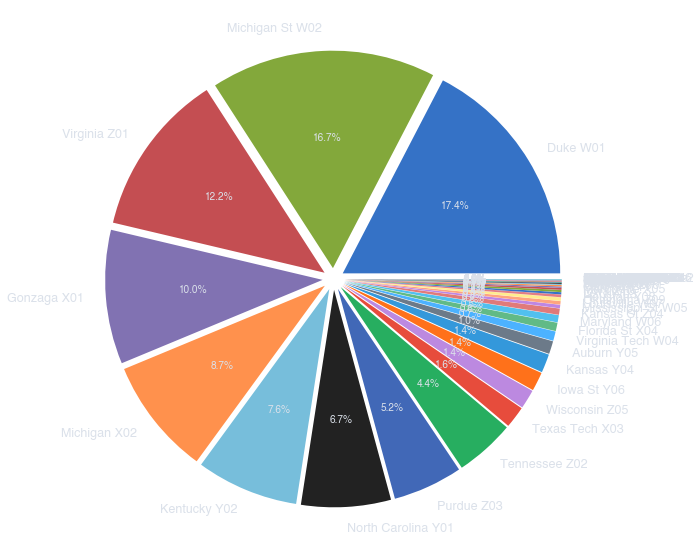

In [24]:
plt.figure(figsize=(10,10));
plt.pie(
    x=pie_df["PercentChampion"],
    labels=pie_df["TeamName"] + " " + pie_df["Seed"],
    autopct="%.1f%%",
    explode=[0.05]*len(simulation_df),
);

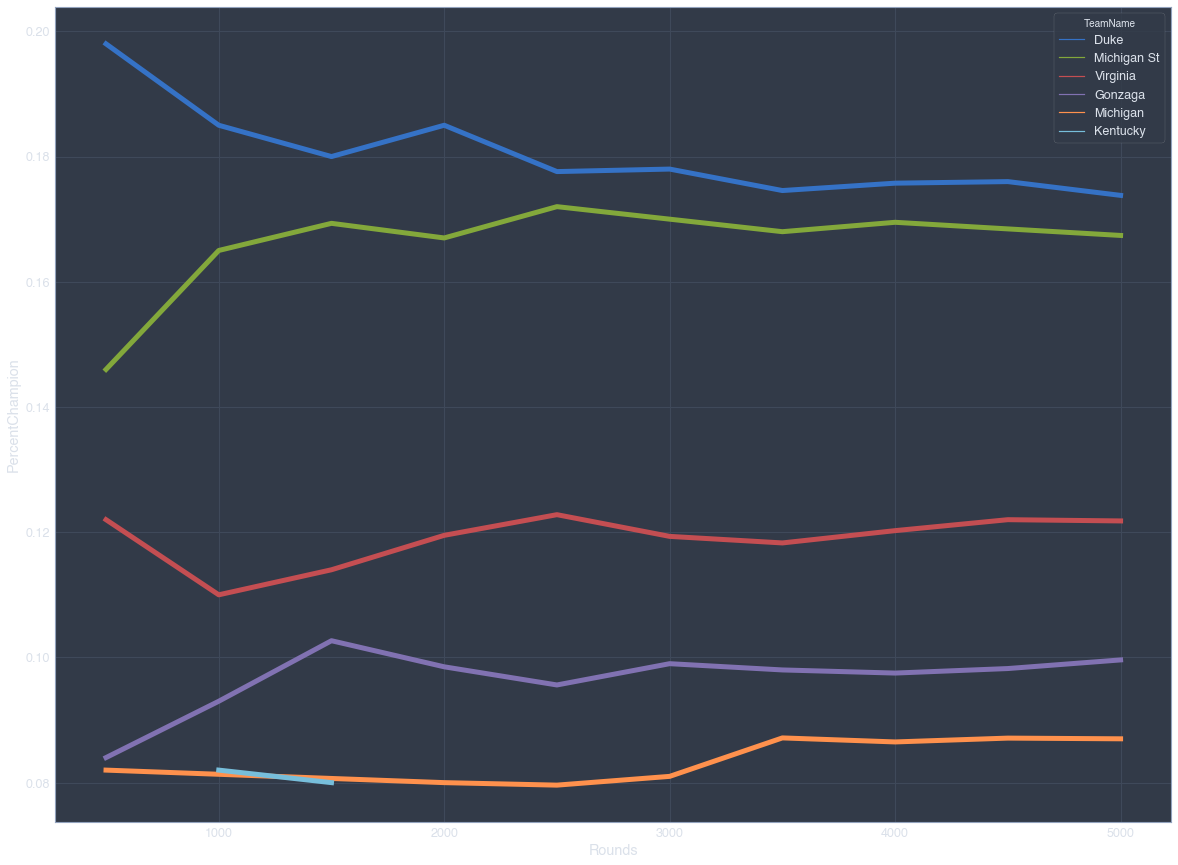

In [25]:
# Confirm % looks stable over time
plt.figure(figsize=(20,15));
progression_df = pd.DataFrame(simulation_progression).merge(
    tournament_df[["TeamID", "TeamName"]], on="TeamID"
)
sns.lineplot(
    data=progression_df,
    x="Rounds", y="PercentChampion", hue="TeamName", linewidth=5
);

In [26]:
 # What is the most common bracket?
bracket_slots = []
for slot, win_dict in slots_wins.items():
    top_teams = sorted(((v, k) for k, v in win_dict.items()), reverse=True)
    max_count, max_team_id = top_teams[0]
    runner_count, runner_team_id = top_teams[1]
    total = sum(v for v in win_dict.values())
    bracket_slots.append({
        "Slot": slot,
        "WinTeamID": max_team_id,
        "WinPct": max_count / total,
        "RunnerTeamID": runner_team_id,
        "RunnerWinPct": runner_count / total,
    })

bracket_df = pd.DataFrame(bracket_slots).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="WinTeamID", right_on="TeamID"
).rename(columns={"TeamName": "WinTeamName", "Seed": "WinSeed"}).merge(
    tournament_df[["TeamID", "TeamName", "Seed"]], left_on="RunnerTeamID", right_on="TeamID"
).rename(columns={"TeamName": "RunnerTeamName", "Seed": "RunnerSeed"})
bracket_df["Round"] = bracket_df["Slot"].apply(lambda x: int(x[1]) if x.startswith("R") else 0)
bracket_df = bracket_df[[
    "Slot", "Round",
    "WinTeamName", "WinSeed", "WinPct",
    "RunnerTeamName", "RunnerSeed", "RunnerWinPct"
]]

In [27]:
bracket_df[bracket_df["Round"] == 4].sort_values("WinPct", ascending=False)

,Slot,Round,WinTeamName,WinSeed,WinPct,RunnerTeamName,RunnerSeed,RunnerWinPct
7,R4W1,4,Duke,W01,0.4442,Michigan St,W02,0.3726
54,R4Z1,4,Virginia,Z01,0.3934,Purdue,Z03,0.2176
24,R4X1,4,Gonzaga,X01,0.3784,Michigan,X02,0.3200
42,R4Y1,4,Kentucky,Y02,0.3438,North Carolina,Y01,0.3116


In [28]:
# Submit to Kaggle
import itertools
predictions = []
for year in range(2015, 2020):
    submit_df = raw_tournament_df[raw_tournament_df["Season"] == year].set_index(["Season", "TeamID"])
    ids = sorted(submit_df.loc[year].index)
    for id_a, id_b in itertools.product(ids, ids):
        if id_a >= id_b:
            continue
        team_a = submit_df.loc[(year, id_a)]
        team_b = submit_df.loc[(year, id_b)]
        predict_data = (
            team_a["OwnScore_Zscore"], team_b["OwnScore_Zscore"],
            team_a["OppScore_Zscore"], team_b["OppScore_Zscore"],
            team_a["Offense"], team_b["Offense"],
            team_a["Dominance"], team_b["Dominance"],
            team_a["SOS"], team_b["SOS"],
            team_a["Competition"], team_b["Competition"],
        )
        prob = calc_prob(predict_data)
        predictions.append({
            "ID": f"{year}_{id_a}_{id_b}",
            "Pred": prob
        })

In [29]:
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(f"{DATA_DIR}/output/kaggle_submission.csv", index=False)